## Generate some diagnostic plots

For each kage:
1. Plot confidence score histograms
2. Remove values with low confidence scores
3. Compute speed in units of cm/sec
4. Plot speed histograms
5. Plot trajectories
6. Plot occupancy heatmaps

The plots are generated per day, as well as per kage (aggregated across all days).

In [1]:
from pathlib import Path

import pandas as pd
import seaborn as sns
import xarray as xr
from matplotlib import pyplot as plt
from movement.filtering import filter_by_confidence
from movement.kinematics import compute_speed
from movement.plots import plot_centroid_trajectory, plot_occupancy
from movement.transforms import scale

from smart_kages_movement.plots import (
    plot_confidence_hist_by_keypoint,
    plot_speed,
)

## Configuration
Define some global variables and paths.

In [2]:
PIXELS_PER_CM = 10  # pixels per centimeter (need to double-check this value)
MOUSE_NAME = "individual_0"  # always the same for this dataset
sns.set_context("notebook")
sns.set_style("ticks")

data_dir = Path.home() / "Data" / "Smart-Kages"
analysis_dir = data_dir / "movement_analysis"

kage_dirs = [
    d
    for d in analysis_dir.iterdir()
    if d.is_dir() and d.name.startswith("kage")
]
kage_names = [d.name for d in kage_dirs]
n_kages = len(kage_dirs)
print(f"Found {n_kages} kages: {kage_names}")

Found 2 kages: ['kage14', 'kage17']


Let's select one kage for demonstration purposes.

In [22]:
# Load 1st kage fron netCDF file
kage_idx = 0  # Change this to select a different kage
kage = kage_names[kage_idx]

ds_kage = xr.open_dataset(kage_dirs[kage_idx] / f"{kage}.nc")

ds_kage

<xarray.Dataset> Size: 1GB
Dimensions:          (time: 5236793, space: 2, keypoints: 8, individuals: 1)
Coordinates:
  * space            (space) <U1 8B 'x' 'y'
  * keypoints        (keypoints) <U10 320B 'snout' 'leftear' ... 'tailbase'
  * individuals      (individuals) <U12 48B 'individual_0'
  * time             (time) datetime64[ns] 42MB 2024-04-08T13:55:40 ... 2024-...
    seconds_elapsed  (time) float64 42MB ...
Data variables:
    position         (time, space, keypoints, individuals) float64 670MB ...
    confidence       (time, keypoints, individuals) float64 335MB ...
Attributes:
    source_software:      DeepLabCut
    ds_type:              poses
    fps:                  2.0
    time_unit:            datetime64[ns]
    source_file:          /Users/nsirmpilatze/Data/Smart-Kages/kage14/analysi...
    kage:                 kage14
    kage_start_datetime:  2024-04-08T13:55:40

## Plot confidence score histograms
These are plotted per keypoint.

First let's plot them aggregated across all days of a kage.

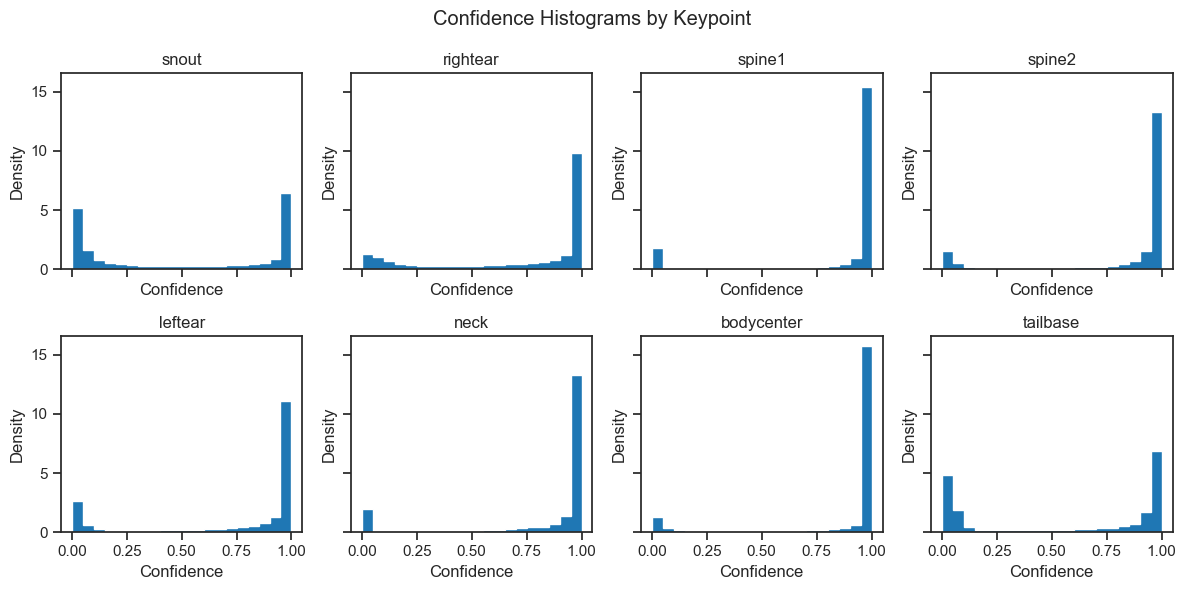

In [23]:
conf_plot_path = analysis_dir / kage / f"{kage}_confidence_histograms.png"
plot_confidence_hist_by_keypoint(ds_kage, save_path=conf_plot_path)

Let's also save confidence histograms for each day:

In [24]:
for date, day_ds in ds_kage.groupby("time.date"):
    daily_plots_dir = analysis_dir / kage / "daily_plots"
    daily_plots_dir.mkdir(parents=True, exist_ok=True)
    plot_confidence_hist_by_keypoint(
        day_ds,
        save_path=(
            daily_plots_dir / f"{date.isoformat()}_confidence_histograms.png"
        ),
    )
    # close the plots to avoid memory issues
    plt.close("all")

print(f"Saved daily confidence histograms for {kage} in {daily_plots_dir}")

Saved daily confidence histograms for kage14 in /Users/nsirmpilatze/Data/Smart-Kages/movement_analysis/kage14/daily_plots


## Filter out low confidence scores
We choose a threshold informed by the confidence score histograms.

The filtered date is stored as a new `positions_filtered` variable in the same dataset.

In [25]:
confidence_threshold = 0.9

ds_kage["position_filtered"] = filter_by_confidence(
    ds_kage.position, ds_kage.confidence, threshold=confidence_threshold
)
ds_kage.position_filtered.attrs["confidence_threshold"] = confidence_threshold

# Let's also define a list of "reliable" keypoints for later use
use_keypoints = ["neck", "spine1", "bodycenter", "spine2"]

## Compute speed in units of cm/sec

- We first set the time index to "seconds_elapsed" to ensure that the
`compute_speed` and `scale` functions work correctly.
- We the scale the filtered position values to cm/sec using the `scale` function. The correctness of speed values depends on the `PIXELS_PER_CM` constant.
- We then compute the speed using the `compute_speed` function, based on the fitlered and scaled position values.
- Finally, we set the time index back to datetime.

The computed speed is stored as a new `speed_cm_per_sec` variable in the same dataset.

In [26]:
speed_cm_per_sec = compute_speed(
    scale(
        ds_kage.position_filtered.set_index(time="seconds_elapsed"),
        factor=1 / PIXELS_PER_CM,
        space_unit="cm",
    )
)
ds_kage["speed_cm_per_sec"] = speed_cm_per_sec.assign_coords(
    time=ds_kage.time,
)

## Plot speed time series and histograms

First let's plot speed across all days of a kage, and then per day.

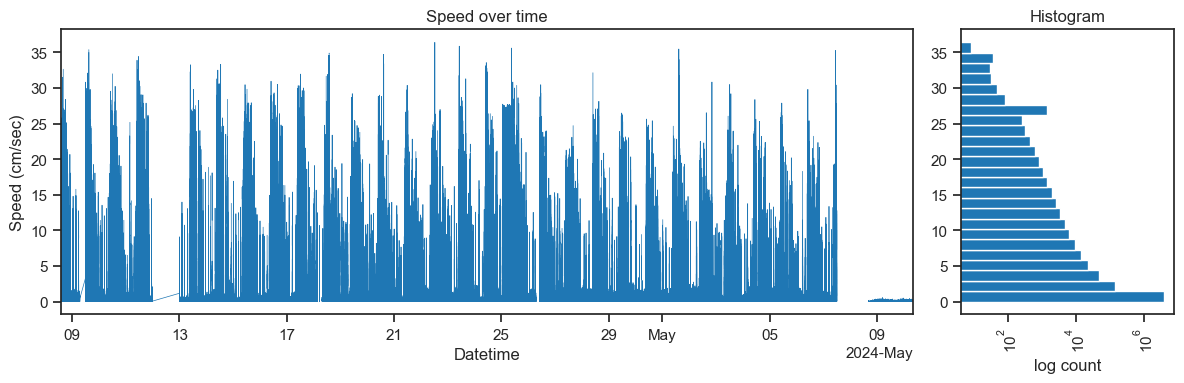

In [27]:
body_speed = ds_kage["speed_cm_per_sec"].sel(
    individuals=MOUSE_NAME, keypoints="bodycenter"
)
speed_plot_path = analysis_dir / kage / f"{kage}_speed.png"
plot_speed(
    body_speed,
    save_path=speed_plot_path,
)

In [28]:
for date, day_ds in ds_kage.groupby("time.date"):
    daily_plots_dir = analysis_dir / kage / "daily_plots"
    plot_speed(
        day_ds["speed_cm_per_sec"].sel(
            individuals=MOUSE_NAME, keypoints="bodycenter"
        ),
        save_path=(daily_plots_dir / f"{date.isoformat()}_speed.png"),
    )
    # close the plots to avoid memory issues
    plt.close("all")

print(f"Saved daily speed plots for {kage} in {daily_plots_dir}")

Saved daily speed plots for kage14 in /Users/nsirmpilatze/Data/Smart-Kages/movement_analysis/kage14/daily_plots


## Plot body trajectories over time

2025-07-31 14:59:06.771 | WARNING  | matplotlib._api:warn_external:391 - /var/folders/w3/q74_bsm5379bzb0hkt1n4bzm0000gn/T/ipykernel_81376/969096999.py:13: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  cbar.set_ticklabels(



(0.0, 500.0)

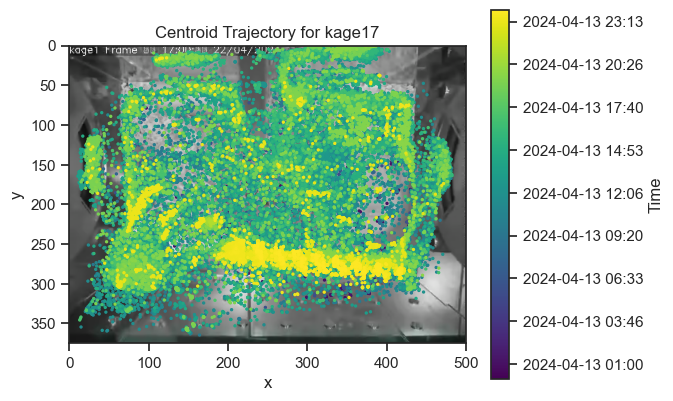

In [19]:
time_window = slice("2024-04-13T00:00:00", "2024-04-14T00:00:00")
background_img = plt.imread(kage_dirs[kage_idx] / f"{kage}_background.png")

fig, ax = plt.subplots()
height, width = background_img.shape[:2]
ax.imshow(background_img)
plot_centroid_trajectory(
    ds_kage.sel(time=time_window).position, ax=ax, s=2, cmap="viridis"
)
# Get the colorbar ticks from the ax and format them as timestamps
cbar = ax.collections[0].colorbar
current_ticks = cbar.get_ticks()
cbar.set_ticklabels(
    [pd.Timestamp(t).strftime("%Y-%m-%d %H:%M") for t in current_ticks]
)
ax.set_title(f"Centroid Trajectory for {ds_kage.kage}")
ax.set_ylim([height - 1, 0])
ax.set_xlim([0, width])

## Plot occupancy heatmaps

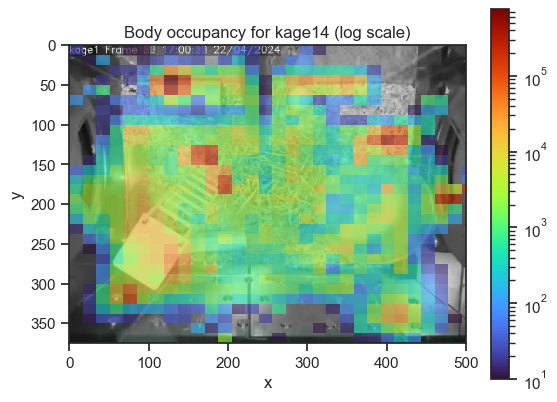

In [29]:
fig, ax = plt.subplots()
ax.imshow(background_img)
plot_occupancy(
    ds_kage.position,
    # conside the centroid of the following keypoints
    keypoints=use_keypoints,
    ax=ax,
    cmap="turbo",
    norm="log",  # log scale the colormap
    cmin=10,  # only show occupancy above 1 frame
    alpha=0.6,  # some transparency
)
# invert y-axis to match the video frame
ax.set_ylim([height - 1, 0])
ax.set_xlim([0, width])
ax.set_title(f"Body occupancy for {ds_kage.kage} (log scale)")

plt.savefig(analysis_dir / kage / f"{kage}_body_occupancy.png")